# 内存代理（Memory Agent）

## 评审（Review）

We created a chatbot that saves semantic memories to a single [user profile](https://langchain-ai.github.io/langgraph/concepts/memory/#profile) or [collection](https://langchain-ai.github.io/langgraph/concepts/memory/#collection).

我们创建了一个聊天机器人，它将语义记忆保存到单一的 [user profile](https://langchain-ai.github.io/langgraph/concepts/memory/#profile) 或 [collection](https://langchain-ai.github.io/langgraph/concepts/memory/#collection)。

We introduced [Trustcall](https://github.com/hinthornw/trustcall) as a way to update either schema.

我们介绍了 [Trustcall](https://github.com/hinthornw/trustcall) 作为一种更新任一模式的方法。

## 目标（Goals）

Now, we're going to pull together the pieces we've learned to build an [agent](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/) with long-term memory.

现在，我们将把学到的内容整合起来，构建一个具有长期记忆的 [agent](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/)。

Our agent, `task_mAIstro`, will help us manage a ToDo list! 

我们的代理 `task_mAIstro` 将帮助我们管理待办事项列表！

The chatbots we built previously *always* reflected on the conversation and saved memories. 

我们之前构建的聊天机器人 *始终* 会反思对话并保存记忆。

`task_mAIstro` will decide *when* to save memories (items to our ToDo list).

`task_mAIstro` 将决定 *何时* 保存记忆（待办事项列表中的项目）。

The chatbots we built previously always saved one type of memory, a profile or a collection. 

我们之前构建的聊天机器人始终保存一种类型的记忆，即个人资料或集合。

`task_mAIstro` can decide to save to either a user profile or a collection of ToDo items.

`task_mAIstro` 可以决定将数据保存到用户个人资料或 ToDo 事项集合中。

In addition semantic memory, `task_mAIstro` also will manage procedural memory.

除此之外，`task_mAIstro` 还将管理程序性记忆。

This allows the user to update their preferences for creating ToDo items. 

这允许用户更新创建ToDo项的偏好设置。



In [19]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph trustcall langchain_core

In [1]:
import os, getpass

def _set_env(var: str):
    # Check if the variable is set in the OS environment
    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")
    
    # Set the environment variable for the current process
    os.environ[var] = env_value

os.environ["LANGSMITH_API_KEY"]="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"
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [ ]:
_set_env("OPENAI_API_KEY")

## 对 Trustcall 更新的可见性（Visibility into Trustcall updates）

Trustcall creates and updates JSON schemas.

Trustcall 创建和更新 JSON 模式。

What if we want visibility into the *specific changes* made by Trustcall?
For example, we saw before that Trustcall has some of its own tools to:

例如，我们之前看到过，Trustcall 有一些自己的工具来：

* Self-correct from validation failures -- [see trace example here](https://smith.langchain.com/public/5cd23009-3e05-4b00-99f0-c66ee3edd06e/r/9684db76-2003-443b-9aa2-9a9dbc5498b7) 
* Update existing documents -- [see trace example here](https://smith.langchain.com/public/f45bdaf0-6963-4c19-8ec9-f4b7fe0f68ad/r/760f90e1-a5dc-48f1-8c34-79d6a3414ac3)

*自纠正验证失败 -- [see trace example here](https://smith.langchain.com/public/5cd23009-3e05-4b00-99f0-c66ee3edd06e/r/9684db76-2003-443b-9aa2-9a9dbc5498b7)* 更新现有文档 -- [see trace example here](https://smith.langchain.com/public/f45bdaf0-6963-4c19-8ec9-f4b7fe0f68ad/r/760f90e1-a5dc-48f1-8c34-79d6a3414ac3)

Visibility into these tools can be useful for the agent we're going to build.

这些工具的可见性对我们即将构建的代理很有用。

Below, we'll show how to do this!

下面，我们将展示如何做到这一点！



In [2]:
from pydantic import BaseModel, Field

class Memory(BaseModel):
    content: str = Field(description="记忆的主要内容。例如：用户表达了学习法语的兴趣。")

class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(description="关于用户的一系列记忆。")

We can add a [listener](https://python.langchain.com/docs/how_to/lcel_cheatsheet/#add-lifecycle-listeners) to the Trustcall extractor.

我们可以向 Trustcall 提取器添加一个 [listener](https://python.langchain.com/docs/how_to/lcel_cheatsheet/#add-lifecycle-listeners)。

This will pass runs from the extractor's execution to a class, `Spy`, that we will define.

这将把提取器执行过程中的运行传递到我们定义的一个类，`Spy`。

Our `Spy` class will extract information about what tool calls were made by Trustcall.

我们的 `Spy` 类将提取 Trustcall 所调用工具的相关信息。



In [5]:
from trustcall import create_extractor
from langchain_openai import ChatOpenAI

# 检查Trustcall进行的工具调用
class Spy:
    def __init__(self):
        self.called_tools = []

    def __call__(self, run):
        # 收集提取器进行的工具调用信息。
        q = [run]
        while q:
            r = q.pop()
            if r.child_runs:
                q.extend(r.child_runs)
            if r.run_type == "chat_model":
                self.called_tools.append(
                    r.outputs["generations"][0][0]["message"]["kwargs"]["tool_calls"]
                )

# 初始化监视器
spy = Spy()

# 初始化模型
from langchain_community.chat_models import ChatTongyi
model = ChatTongyi(
    model="qwen-plus-2025-07-14",
    api_key="sk-ba2dda3817f145d7af141fdf32e31d90"
)

# 创建提取器
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    enable_inserts=True,
)

# 添加监视器作为监听器
trustcall_extractor_see_all_tool_calls = trustcall_extractor.with_listeners(on_end=spy)

In [6]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# 指令
instruction = """从以下对话中提取记忆："""

# 对话
conversation = [HumanMessage(content="嗨，我是兰斯。"), 
                AIMessage(content="很高兴认识你，兰斯。"), 
                HumanMessage(content="今天早上我在旧金山骑了一次很棒的自行车。")]

# 调用提取器
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=instruction)] + conversation})

In [7]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_c12fc2f5da584c6ca54228)
 Call ID: call_c12fc2f5da584c6ca54228
  Args:
    content: 用户今天早上在旧金山骑了一次很棒的自行车。


In [8]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]: 
    print(m)

content='用户今天早上在旧金山骑了一次很棒的自行车。'


In [9]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'call_c12fc2f5da584c6ca54228'}


In [10]:
# 更新对话
updated_conversation = [AIMessage(content="太好了，之后你做了什么？"), 
                        HumanMessage(content="我去了Tartine，吃了一个可颂面包。"),                        
                        AIMessage(content="还有什么想法吗？"),
                        HumanMessage(content="我在想我的日本之行，今年冬天想再去一次！")]

# 更新指令
system_msg = """根据以下对话更新现有记忆并创建新的记忆："""

# 我们将保存现有记忆，给它们分配ID、键（工具名称）和值
tool_name = "Memory"
existing_memories = [(str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])] if result["responses"] else None
existing_memories

[('0', 'Memory', {'content': '用户今天早上在旧金山骑了一次很棒的自行车。'})]

In [14]:

# 使用更新的对话和现有记忆调用提取器，增加递归限制
result = trustcall_extractor_see_all_tool_calls.invoke(
    {"messages": updated_conversation, 
     "existing": existing_memories},
    {"recursion_limit": 100} #增加递归限制到50
)

GraphRecursionError: Recursion limit of 100 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [14]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'call_bF0w0hE4YZmGyDbuJVe1mh5H', 'json_doc_id': '0'}
{'id': 'call_fQAxxRypV914Xev6nJ9VKw3X'}


In [10]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_bF0w0hE4YZmGyDbuJVe1mh5H)
 Call ID: call_bF0w0hE4YZmGyDbuJVe1mh5H
  Args:
    content: Lance had a nice bike ride in San Francisco this morning. Afterward, he went to Tartine and ate a croissant. He was also thinking about his trip to Japan and going back this winter.
  Memory (call_fQAxxRypV914Xev6nJ9VKw3X)
 Call ID: call_fQAxxRypV914Xev6nJ9VKw3X
  Args:
    content: Lance went to Tartine and ate a croissant. He was also thinking about his trip to Japan and going back this winter.


In [18]:
# Parsed responses
for m in result["responses"]:
    print(m)

content='Lance had a nice bike ride in San Francisco this morning. Afterward, he went to Tartine and ate a croissant. He was also thinking about his trip to Japan and going back this winter.'
content='Lance went to Tartine and ate a croissant. He was also thinking about his trip to Japan and going back this winter.'


In [12]:
# Inspect the tool calls made by Trustcall
spy.called_tools

[[{'name': 'PatchDoc',
   'args': {'json_doc_id': '0',
    'planned_edits': '1. Replace the existing content with the updated memory that includes the new activities: going to Tartine for a croissant and thinking about going back to Japan this winter.',
    'patches': [{'op': 'replace',
      'path': '/content',
      'value': 'Lance had a nice bike ride in San Francisco this morning. Afterward, he went to Tartine and ate a croissant. He was also thinking about his trip to Japan and going back this winter.'}]},
   'id': 'call_bF0w0hE4YZmGyDbuJVe1mh5H',
   'type': 'tool_call'},
  {'name': 'Memory',
   'args': {'content': 'Lance went to Tartine and ate a croissant. He was also thinking about his trip to Japan and going back this winter.'},
   'id': 'call_fQAxxRypV914Xev6nJ9VKw3X',
   'type': 'tool_call'}]]

In [19]:
def extract_tool_info(tool_calls, schema_name="Memory"):
    """Extract information from tool calls for both patches and new memories.
    
    Args:
        tool_calls: List of tool calls from the model
        schema_name: Name of the schema tool (e.g., "Memory", "ToDo", "Profile")
    """

    # Initialize list of changes
    changes = []
    
    for call_group in tool_calls:
        for call in call_group:
            if call['name'] == 'PatchDoc':
                changes.append({
                    'type': 'update',
                    'doc_id': call['args']['json_doc_id'],
                    'planned_edits': call['args']['planned_edits'],
                    'value': call['args']['patches'][0]['value']
                })
            elif call['name'] == schema_name:
                changes.append({
                    'type': 'new',
                    'value': call['args']
                })

    # Format results as a single string
    result_parts = []
    for change in changes:
        if change['type'] == 'update':
            result_parts.append(
                f"Document {change['doc_id']} updated:\n"
                f"Plan: {change['planned_edits']}\n"
                f"Added content: {change['value']}"
            )
        else:
            result_parts.append(
                f"New {schema_name} created:\n"
                f"Content: {change['value']}"
            )
    
    return "\n\n".join(result_parts)

# Inspect spy.called_tools to see exactly what happened during the extraction
schema_name = "Memory"
changes = extract_tool_info(spy.called_tools, schema_name)
print(changes)

Document 0 updated:
Plan: 1. Replace the existing content with the updated memory that includes the new activities: going to Tartine for a croissant and thinking about going back to Japan this winter.
Added content: Lance had a nice bike ride in San Francisco this morning. Afterward, he went to Tartine and ate a croissant. He was also thinking about his trip to Japan and going back this winter.

New Memory created:
Content: {'content': 'Lance went to Tartine and ate a croissant. He was also thinking about his trip to Japan and going back this winter.'}


## 创建一个代理（Creating an agent）

There are many different [agent](https://langchain-ai.github.io/langgraph/concepts/high_level/) architectures to choose from.

有许多不同的 [agent](https://langchain-ai.github.io/langgraph/concepts/high_level/) 架构可供选择。

Here, we'll implement something simple, a [ReAct](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#react-implementation) agent.

在这里，我们将实现一个简单的内容，一个 [ReAct](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#react-implementation) 代理。

This agent will be a helpful companion for creating and managing a ToDo list.

这个代理将成为创建和管理待办事项列表的得力助手。

This agent can make a decision to update three types of long-term memory: 

此代理可以决定更新三种类型的长期记忆：

(a) Create or update a user `profile` with general user information 

(a) 创建或更新具有普通用户信息的用户 `profile`

(b) Add or update items in a ToDo list `collection`

(b) 在ToDo列表中添加或更新项目 `collection`

(c) Update its own `instructions` on how to update items to the ToDo list

(c) 更新其自身的 `instructions` 以了解如何更新待办事项列表中的项目



In [18]:
from typing import TypedDict, Literal

# 更新记忆工具
class UpdateMemory(TypedDict):
    """ 决定更新哪种记忆类型 """
    update_type: Literal['user', 'todo', 'instructions']

In [33]:
def extract_tool_info(tool_calls, schema_name="Memory"):
    """从工具调用中提取信息，包括补丁和新记忆。
    
    参数:
        tool_calls: 模型的工具调用列表
        schema_name: 模式工具的名称（例如，"Memory", "ToDo", "Profile"）
    """

    # 初始化变更列表
    changes = []
    
    for call_group in tool_calls:
        for call in call_group:
            if call['name'] == 'PatchDoc':
                changes.append({
                    'type': 'update',
                    'doc_id': call['args']['json_doc_id'],
                    'planned_edits': call['args']['planned_edits'],
                    'value': call['args']['patches'][0]['value']
                })
            elif call['name'] == schema_name:
                changes.append({
                    'type': 'new',
                    'value': call['args']
                })

    # 将结果格式化为单个字符串
    result_parts = []
    for change in changes:
        if change['type'] == 'update':
            result_parts.append(
                f"文档 {change['doc_id']} 已更新:\n"
                f"计划: {change['planned_edits']}\n"
                f"新增内容: {change['value']}"
            )
        else:
            result_parts.append(
                f"新 {schema_name} 已创建:\n"
                f"内容: {change['value']}"
            )
    
    return "\n\n".join(result_parts)

In [3]:
_set_env("OPENAI_API_KEY")

## 图定义（Graph definition）

We add a simple router, `route_message`, that makes a binary decision to save memories.

我们添加了一个简单的路由器 `route_message`，它通过二元决策来节省内存。

The memory collection updating is handled by `Trustcall` in the `write_memory` node, as before!

内存集合的更新由 `Trustcall` 在 `write_memory` 节点中处理，和之前一样！



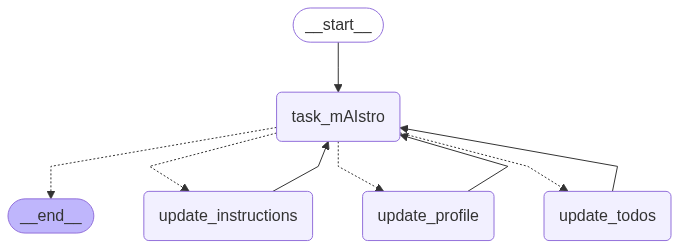

In [34]:
import uuid
from IPython.display import Image, display
from datetime import datetime
from trustcall import create_extractor
from typing import Optional
from pydantic import BaseModel, Field
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import merge_message_runs, HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, END, START
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore
from langchain_openai import ChatOpenAI
from langchain_community.chat_models import ChatTongyi
from typing import Optional, Literal
# 初始化模型
model = ChatTongyi(
    model="qwen-plus-2025-07-14",
    api_key="sk-ba2dda3817f145d7af141fdf32e31d90"
)

# 用户档案模式
class Profile(BaseModel):
    """这是您聊天用户的档案"""
    name: Optional[str] = Field(description="用户的姓名", default=None)
    location: Optional[str] = Field(description="用户的位置", default=None)
    job: Optional[str] = Field(description="用户的工作", default=None)
    connections: list[str] = Field(
        description="用户的个人联系人，如家人、朋友或同事",
        default_factory=list
    )
    interests: list[str] = Field(
        description="用户的兴趣", 
        default_factory=list
    )

# 待办事项模式
class ToDo(BaseModel):
    task: str = Field(description="要完成的任务。")
    time_to_complete: Optional[int] = Field(description="完成任务的估计时间（分钟）。")
    deadline: Optional[datetime] = Field(
        description="任务需要完成的时间（如果适用）",
        default=None
    )
    solutions: list[str] = Field(
        description="具体可行的解决方案列表（例如，与完成任务相关的具体想法、服务提供商或具体选项）",
        min_items=1,
        default_factory=list
    )
    status: Literal["not started", "in progress", "done", "archived"] = Field(
        description="任务的当前状态",
        default="not started"
    )

# 创建Trustcall提取器用于更新用户档案
profile_extractor = create_extractor(
    model,
    tools=[Profile]
)

# 聊天机器人指令，用于选择要更新的内容和调用的工具
MODEL_SYSTEM_MESSAGE = """您是一个有用的聊天机器人。
您被设计为用户的伴侣，帮助他们跟踪待办事项列表。
您有一个长期记忆，用于跟踪三件事：
1. 用户档案（关于他们的通用信息）
2. 用户的待办事项列表
3. 更新待办事项列表的通用指令

以下是当前用户档案（如果没有收集到信息则可能为空）：
<user_profile>
{user_profile}
</user_profile>

以下是当前待办事项列表（如果没有添加任务则可能为空）：
<todo>
{todo}
</todo>

以下是用户指定的更新待办事项列表的当前偏好（如果没有指定偏好则可能为空）：
<instructions>
{instructions}
</instructions>

以下是您处理用户消息的指令：
1. 仔细思考下面呈现的用户消息。
2. 决定是否需要更新您的长期记忆：
- 如果提供了关于用户的个人信息，通过调用UpdateMemory工具（类型为`user`）更新用户档案
- 如果提到了任务，通过调用UpdateMemory工具（类型为`todo`）更新待办事项列表
- 如果用户指定了更新待办事项列表的偏好，通过调用UpdateMemory工具（类型为`instructions`）更新指令
3. 在适当的时候告诉用户您已更新记忆：
- 不要告诉用户您已更新用户档案
- 当您更新待办事项列表时要告诉用户
- 不要告诉用户您已更新指令
4. 倾向于更新待办事项列表。无需请求明确许可。
5. 在工具调用保存记忆后，或如果没有进行工具调用时，自然地回应用户。"""

# Trustcall指令
TRUSTCALL_INSTRUCTION = """反思以下互动。
使用提供的工具保留关于用户的任何必要记忆。
使用并行工具调用来同时处理更新和插入。
系统时间：{time}"""

# 更新待办事项列表的指令
CREATE_INSTRUCTIONS = """反思以下互动。
基于此互动，更新您更新待办事项列表项的指令。
使用用户提供的任何反馈来更新他们喜欢如何添加项目等。
您当前的指令是：
<current_instructions>
{current_instructions}
</current_instructions>"""

# 节点定义
def task_mAIstro(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """从存储中加载记忆，并使用它们来个性化聊天机器人的回应。"""
    # 从配置中获取用户ID
    user_id = config["configurable"]["user_id"]
    # 从存储中检索档案记忆
    namespace = ("profile", user_id)
    memories = store.search(namespace)
    if memories:
        user_profile = memories[0].value
    else:
        user_profile = None
    # 从存储中检索任务记忆
    namespace = ("todo", user_id)
    memories = store.search(namespace)
    todo = "\n".join(f"{mem.value}" for mem in memories)
    # 检索自定义指令
    namespace = ("instructions", user_id)
    memories = store.search(namespace)
    if memories:
        instructions = memories[0].value
    else:
        instructions = ""
    system_msg = MODEL_SYSTEM_MESSAGE.format(user_profile=user_profile, todo=todo, instructions=instructions)
    # 使用记忆以及聊天历史来回应
    response = model.bind_tools([UpdateMemory], parallel_tool_calls=False).invoke([SystemMessage(content=system_msg)]+state["messages"])
    return {"messages": [response]}

def update_profile(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """反思聊天历史并更新记忆集合。"""
    # 从配置中获取用户ID
    user_id = config["configurable"]["user_id"]
    # 定义记忆的命名空间
    namespace = ("profile", user_id)
    # 检索最近的记忆作为上下文
    existing_items = store.search(namespace)
    # 为Trustcall提取器格式化现有记忆
    tool_name = "Profile"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )
    # 合并聊天历史和指令
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))
    # 调用提取器
    result = profile_extractor.invoke({"messages": updated_messages, 
                                         "existing": existing_memories})
    # 将Trustcall的记忆保存到存储中
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "已更新档案", "tool_call_id":tool_calls[0]['id']}]}

def update_todos(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """反思聊天历史并更新记忆集合。"""
    # 从配置中获取用户ID
    user_id = config["configurable"]["user_id"]
    # 定义记忆的命名空间
    namespace = ("todo", user_id)
    # 检索最近的记忆作为上下文
    existing_items = store.search(namespace)
    # 为Trustcall提取器格式化现有记忆
    tool_name = "ToDo"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )
    # 合并聊天历史和指令
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))
    # 初始化监视器以查看Trustcall进行的工具调用
    spy = Spy()
    # 创建Trustcall提取器用于更新待办事项列表
    todo_extractor = create_extractor(
    model,
    tools=[ToDo],
    enable_inserts=True
    ).with_listeners(on_end=spy)
    # 调用提取器
    result = todo_extractor.invoke({"messages": updated_messages, 
                                    "existing": existing_memories})
    # 将Trustcall的记忆保存到存储中
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
    # 回应task_mAIstro中的工具调用，确认更新
    tool_calls = state['messages'][-1].tool_calls
    # 提取Trustcall所做的更改，并添加到返回给task_mAIstro的ToolMessage中
    todo_update_msg = extract_tool_info(spy.called_tools, tool_name)
    return {"messages": [{"role": "tool", "content": todo_update_msg, "tool_call_id":tool_calls[0]['id']}]}

def update_instructions(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """反思聊天历史并更新记忆集合。"""
    # 从配置中获取用户ID
    user_id = config["configurable"]["user_id"]
    namespace = ("instructions", user_id)
    existing_memory = store.get(namespace, "user_instructions")
    # 在系统提示中格式化记忆
    system_msg = CREATE_INSTRUCTIONS.format(current_instructions=existing_memory.value if existing_memory else None)
    new_memory = model.invoke([SystemMessage(content=system_msg)]+state['messages'][:-1] + [HumanMessage(content="请根据对话更新指令")])
    # 覆盖存储中的现有记忆
    key = "user_instructions"
    store.put(namespace, key, {"memory": new_memory.content})
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "已更新指令", "tool_call_id":tool_calls[0]['id']}]}

# 条件边
def route_message(state: MessagesState, config: RunnableConfig, store: BaseStore) -> Literal[END, "update_todos", "update_instructions", "update_profile"]:
    """反思记忆和聊天历史以决定是否更新记忆集合。"""
    message = state['messages'][-1]
    if len(message.tool_calls) ==0:
        return END
    else:
        tool_call = message.tool_calls[0]
        if tool_call['args']['update_type'] == "user":
            return "update_profile"
        elif tool_call['args']['update_type'] == "todo":
            return "update_todos"
        elif tool_call['args']['update_type'] == "instructions":
            return "update_instructions"
        else:
            raise ValueError

# 创建图+所有节点
builder = StateGraph(MessagesState)
# 定义记忆提取过程的流程
builder.add_node(task_mAIstro)
builder.add_node(update_todos)
builder.add_node(update_profile)
builder.add_node(update_instructions)
builder.add_edge(START, "task_mAIstro")
builder.add_conditional_edges("task_mAIstro", route_message)
builder.add_edge("update_todos", "task_mAIstro")
builder.add_edge("update_profile", "task_mAIstro")
builder.add_edge("update_instructions", "task_mAIstro")

# 用于长期（跨线程）记忆的存储
across_thread_memory = InMemoryStore()
# 用于短期（线程内）记忆的检查点
within_thread_memory = MemorySaver()
# 我们使用检查点和存储来编译图
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)
# 查看
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [36]:
# 我们为短期（线程内）记忆提供线程ID
# 我们为长期（跨线程）记忆提供用户ID
config = {"configurable": {"thread_id": "1", "user_id": "Lance"}}

# 用户输入以创建档案记忆
input_messages = [HumanMessage(content="我的名字是Lance。我和我的妻子住在旧金山。我有一个1岁的女儿。")]

# 运行图
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

我的名字是Lance。我和我的妻子住在旧金山。我有一个1岁的女儿。
================================== Ai Message ==================================

已了解，Lance！旧金山有家人陪伴一定很幸福。如果你有任何需要帮忙管理的任务或事项，随时告诉我，我会帮你记着。


In [37]:
# 用户输入待办事项
input_messages = [HumanMessage(content="我妻子让我为宝宝预订游泳课。")]

# 运行图
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

我妻子让我为宝宝预订游泳课。
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_6977090b86d94250b68b2d)
 Call ID: call_6977090b86d94250b68b2d
  Args:
    update_type: todo
================================= Tool Message =================================

新 ToDo 已创建:
内容: {'task': '为宝宝预订游泳课', 'time_to_complete': 30, 'solutions': ['查找旧金山地区提供婴儿游泳课程的机构，如Goldfish Swim School或Dive Rite Swim School', '查看Yelp或Google评价选择评分高的课程', '联系2-3家机构咨询课程安排、费用和试听课'], 'deadline': '2025-08-10T00:00:00', 'status': 'not started'}
================================== Ai Message ==================================

好的，Lance，我已经为你创建了一个待办事项：为宝宝预订游泳课。我会帮你跟踪这个任务，直到完成。目前状态是“未开始”，如果你需要我协助查找课程或联系机构，随时告诉我！


In [38]:
# 用户输入以更新创建待办事项的指令
input_messages = [HumanMessage(content="在创建或更新待办事项时，包含特定的本地企业/供应商。")]

# 运行图
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

在创建或更新待办事项时，包含特定的本地企业/供应商。
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_7b570af7c32240eabc06cc)
 Call ID: call_7b570af7c32240eabc06cc
  Args:
    update_type: instructions
================================= Tool Message =================================

已更新指令
================================== Ai Message ==================================

已更新你的偏好：在创建或更新待办事项时，我会包含具体的本地企业或供应商建议。例如，在为宝宝预订游泳课的任务中，我已经列出了像Goldfish Swim School和Dive Rite Swim School这样的本地机构。如果你有其他任务，我也会照此处理。


In [40]:
# 检查更新的指令
user_id = "Lance"

# 搜索
for memory in across_thread_memory.search(("instructions", user_id)):
    print(memory.value)

{'memory': ''}


In [41]:
# 用户输入待办事项
input_messages = [HumanMessage(content="我需要修理门上卡住的电动耶鲁锁。")]

# 运行图
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

我需要修理门上卡住的电动耶鲁锁。
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_b68dc286b69845c6bd0d4f)
 Call ID: call_b68dc286b69845c6bd0d4f
  Args:
    update_type: todo


GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [28]:
# Namespace for the memory to save
user_id = "Lance"

# Search 
for memory in across_thread_memory.search(("todo", user_id)):
    print(memory.value)

{'task': 'Book swim lessons for 1-year-old daughter.', 'time_to_complete': 30, 'deadline': None, 'solutions': ['Check local swim schools in SF', 'Look for baby swim classes online', 'Ask friends for recommendations', 'Contact La Petite Baleen Swim School', 'Check with SF Recreation and Parks for classes'], 'status': 'not started'}
{'task': 'Fix the jammed electric Yale lock on the door.', 'time_to_complete': 60, 'deadline': None, 'solutions': ['Contact a local locksmith in SF', "Check Yale's customer support for troubleshooting", 'Look for repair guides online'], 'status': 'not started'}


In [29]:
# User input to update an existing ToDo
input_messages = [HumanMessage(content="For the swim lessons, I need to get that done by end of November.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

For the swim lessons, I need to get that done by end of November.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_6AbsrTps4EPyD0gKBzkMIC90)
 Call ID: call_6AbsrTps4EPyD0gKBzkMIC90
  Args:
    update_type: todo
================================= Tool Message =================================

Document ed0af900-52fa-4f15-907c-1aed1e17b0ce updated:
Plan: Add a deadline for the swim lessons task to ensure it is completed by the end of November.
Added content: 2024-11-30T23:59:59
================================== Ai Message ==================================

I've updated the swim lessons task with a deadline to be completed by the end of November. If there's anything else you need, just let me know!


We can see that Trustcall performs patching of the existing memory:

我们可以看到 Trustcall 对现有内存进行了修补：

https://smith.langchain.com/public/4ad3a8af-3b1e-493d-b163-3111aa3d575a/r



In [30]:
# User input for a ToDo
input_messages = [HumanMessage(content="Need to call back City Toyota to schedule car service.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Need to call back City Toyota to schedule car service.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_tDuYZL7njpwOkg2YMEcf6DDJ)
 Call ID: call_tDuYZL7njpwOkg2YMEcf6DDJ
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Call back City Toyota to schedule car service.', 'time_to_complete': 10, 'solutions': ["Find City Toyota's contact number", 'Check car service availability', 'Prepare car details for service scheduling'], 'status': 'not started'}

Document a77482f0-d654-4b41-ab74-d6f2b343a969 updated:
Plan: Add specific local businesses or vendors to the solutions for fixing the jammed electric Yale lock.
Added content: Contact City Locksmith SF
================================== Ai Message ==================================

I've added "Call ba

In [31]:
# Namespace for the memory to save
user_id = "Lance"

# Search 
for memory in across_thread_memory.search(("todo", user_id)):
    print(memory.value)

{'task': 'Book swim lessons for 1-year-old daughter.', 'time_to_complete': 30, 'deadline': '2024-11-30T23:59:59', 'solutions': ['Check local swim schools in SF', 'Look for baby swim classes online', 'Ask friends for recommendations', 'Contact La Petite Baleen Swim School', 'Check with SF Recreation and Parks for classes'], 'status': 'not started'}
{'task': 'Fix the jammed electric Yale lock on the door.', 'time_to_complete': 60, 'deadline': None, 'solutions': ['Contact a local locksmith in SF', "Check Yale's customer support for troubleshooting", 'Look for repair guides online', 'Contact City Locksmith SF', 'Visit SF Lock and Key for assistance'], 'status': 'not started'}
{'task': 'Call back City Toyota to schedule car service.', 'time_to_complete': 10, 'deadline': None, 'solutions': ["Find City Toyota's contact number", 'Check car service availability', 'Prepare car details for service scheduling'], 'status': 'not started'}


Now we can create a new thread.

现在我们可以创建一个新线程。

This creates a new session. 

这将创建一个新会话。

Profile, ToDos, and Instructions saved to long-term memory are accessed. 

访问了保存到长期记忆中的个人资料、待办事项和指示。



In [32]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "Lance"}}

# Chat with the chatbot
input_messages = [HumanMessage(content="I have 30 minutes, what tasks can I get done?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I have 30 minutes, what tasks can I get done?
================================== Ai Message ==================================

You can work on the following tasks that fit within your 30-minute timeframe:

1. **Book swim lessons for your 1-year-old daughter.** 
   - Estimated time to complete: 30 minutes
   - Solutions include checking local swim schools in SF, looking for baby swim classes online, asking friends for recommendations, contacting La Petite Baleen Swim School, or checking with SF Recreation and Parks for classes.

2. **Call back City Toyota to schedule car service.**
   - Estimated time to complete: 10 minutes
   - Solutions include finding City Toyota's contact number, checking car service availability, and preparing car details for service scheduling.

You can choose either of these tasks to complete within your available time.


In [33]:
# Chat with the chatbot
input_messages = [HumanMessage(content="Yes, give me some options to call for swim lessons.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Yes, give me some options to call for swim lessons.
================================== Ai Message ==================================

Here are some options you can consider for booking swim lessons for your 1-year-old daughter in San Francisco:

1. **La Petite Baleen Swim School**: Known for their baby swim classes, you can contact them to inquire about their schedule and availability.

2. **SF Recreation and Parks**: They often offer swim classes for young children. Check their website or contact them for more information.

3. **Local Swim Schools**: Search for other local swim schools in SF that offer baby swim classes. You might find some good options nearby.

4. **Ask Friends for Recommendations**: Reach out to friends or family in the area who might have experience with swim lessons for young children.

These options should help you get started on booking swim lessons.


Trace: 

https://smith.langchain.com/public/84768705-be91-43e4-8a6f-f9d3cee93782/r

## Studio
![Screenshot 2024-11-04 at 1.00.19 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/6732cfb05d9709862eba4e6c_Screenshot%202024-11-11%20at%207.46.40%E2%80%AFPM.png)

